In [2]:
! pip install --quiet git-remote-codecommit


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import boto3
import sagemaker
import time
from time import strftime

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto3.client("sagemaker")
region = boto_session.region_name
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account = sagemaker_session.boto_session.client("sts").get_caller_identity()["Account"]

prefix = 'sagemaker-intel-dvc'

print(f"account: {account}")
print(f"bucket: {bucket}")
print(f"region: {region}")
print(f"role: {role}")

account: 629171115321
bucket: sagemaker-us-east-1-629171115321
region: us-east-1
role: arn:aws:iam::629171115321:role/service-role/AmazonSageMaker-ExecutionRole-20221203T100950


In [4]:
from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role

In [5]:
dvc_repo_url = "codecommit::us-east-1://sagemaker-intel-classification"
dvc_branch = "processed-dataset"

In [6]:
pytorch_processor = PyTorchProcessor(
    framework_version='1.12',
    py_version="py38",
    role=get_execution_role(),
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='preprocess-intel-dataset',
    env={
        "DVC_REPO_URL": dvc_repo_url,
        "DVC_BRANCH": dvc_branch,
        "GIT_USER": "sushant",
        "GIT_EMAIL": "sushantgautm@gmail.com"
    }
)

In [7]:
input_dataset = "s3://sagemaker-us-east-1-629171115321/intel.zip"

In [10]:
pytorch_processor.run(
    code='preprocess.py',
    # source_dir=',
    dependencies=["requirements.txt"],
    inputs=[
        ProcessingInput(
            input_name='data',
            source=input_dataset,
            destination='/opt/ml/processing/input'
        )
    ],
    # outputs=[
    #     ProcessingOutput(output_name='data_structured', source='/opt/ml/processing/tmp/data_structured', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
    #     ProcessingOutput(output_name='train', source='/opt/ml/processing/output/train', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
    #     ProcessingOutput(output_name='validation', source='/opt/ml/processing/output/val', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
    #     ProcessingOutput(output_name='test', source='/opt/ml/processing/output/test', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'),
    #     ProcessingOutput(output_name='logs', source='/opt/ml/processing/logs', destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}')
    # ]
)


Job Name:  preprocess-intel-dataset-2022-12-17-12-06-28-159
Inputs:  [{'InputName': 'data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-629171115321/intel.zip', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-629171115321/preprocess-intel-dataset-2022-12-17-12-06-28-159/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'entrypoint', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-629171115321/preprocess-intel-dataset-2022-12-17-12-06-28-159/source/runproc.sh', 'LocalPath': '/opt/ml/processing/input/entrypoint', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistribution

### Rest other cells is not used yet.

In [ ]:
%pwd

'/root/flower-project'

In [ ]:
! aws s3 cp s3://sagemaker-ap-south-1-006547668672/flowers.zip .

download: s3://sagemaker-ap-south-1-006547668672/flowers.zip to ./flowers.zip


In [ ]:
from torchvision.datasets.utils import extract_archive

from pathlib import Path

In [ ]:
%pwd

'/root/flower-project'

In [ ]:
dataset_zip = Path("/root/flower-project/flowers.zip")
dataset_extracted = Path("/root/flower-project/")

In [ ]:
extract_archive(
    from_path=dataset_zip,
    to_path=dataset_extracted
)

PosixPath('/root/flower-project')

In [ ]:
dataset_full = list((dataset_extracted / "flowers").glob("*/*.jpg"))
labels = [x.parent.stem for x in dataset_full]

In [ ]:
import numpy as np

In [ ]:
from collections import Counter

In [ ]:
Counter(labels)

Counter({'daisy': 764,
         'dandelion': 1052,
         'tulip': 984,
         'rose': 784,
         'sunflower': 733})

In [ ]:
! pip install --quiet scikit-learn


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
dataset_full[0], labels[0]

(PosixPath('/root/flower-project/flowers/daisy/4694734757_5c563d38dd_n.jpg'),
 'daisy')

In [ ]:
dataset_full[0].name

'4694734757_5c563d38dd_n.jpg'

In [ ]:
d_train, d_test = train_test_split(dataset_full, stratify=labels)

In [ ]:
Counter(x.parent.stem for x in d_train)

Counter({'sunflower': 549,
         'dandelion': 789,
         'tulip': 738,
         'rose': 588,
         'daisy': 573})

In [ ]:
Counter(x.parent.stem for x in d_test)

Counter({'daisy': 191,
         'tulip': 246,
         'dandelion': 263,
         'sunflower': 184,
         'rose': 196})

In [ ]:
git_path = Path("/root/flower-project/example-git")
for path in ['train', 'test']:
        output_dir = git_path / "dataset" / path
        output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
import shutil

In [ ]:
def write_dataset(image_paths, output_dir):
    for img_path in image_paths:
        Path(output_dir / img_path.parent.stem).mkdir(parents=True, exist_ok=True)
        shutil.copyfile(img_path, output_dir / img_path.parent.stem / img_path.name)

In [ ]:
write_dataset(d_train, git_path / "dataset" / "train")
write_dataset(d_test, git_path / "dataset" / "test")

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
img_dset = ImageFolder(git_path / "dataset" / "train")

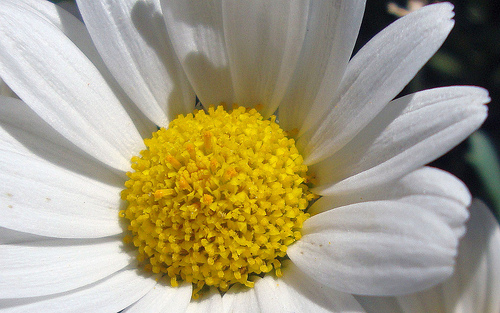

In [ ]:
img_dset[0][0]

In [ ]:
img_dset = ImageFolder(git_path / "dataset" / "test")

In [ ]:
img_dset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']